In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, util, plot_style

In [2]:
import os

print(os.getcwd())

c:\Users\caele\Desktop\Spring2025\miller-lab-final\figures\figure7


In [3]:
# task parameters
numPairs = 5
dt = 1e-5
seq_len = 6
sequences = lrt.make_all_sequences(seq_len, ['L', 'R'])
equil_duration = 2

In [4]:
# load reliabilities
reliabilities = np.load('../figure6/data_1/reliabilities.npy', allow_pickle=True)
print(reliabilities.shape)

(1000,)


In [5]:
np.argsort(reliabilities)[-3:]

array([715, 157, 202], dtype=int64)

In [6]:
reliabilities[np.argsort(reliabilities)[-10:]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
Wji, pset, amp, dur, l_kernel, r_kernel = util.load_fiducial_network(True)

In [8]:
def run_trial(i, amp):
    rng = np.random.default_rng(i)
    
    # make kernels -- same mean
    l_kernel = rng.lognormal(0, 1, numPairs)
    l_kernel = l_kernel / np.sum(l_kernel) * numPairs
    l_kernel = np.round(l_kernel, 5)
    r_kernel = rng.lognormal(0, 1, numPairs)
    r_kernel = r_kernel / np.sum(r_kernel) * numPairs
    r_kernel = np.round(r_kernel, 5)
    
    # make stimuli
    stim_map = lrt.make_stim_map(numPairs, amp, dur, l_kernel, r_kernel, dt)
    
    # make FSM
    FSM = lrt.make_FSM(numPairs, pset, Wji, stim_map, 2, dt=dt)
    
    reliability = lrt.FSM_reliability(sequences, FSM)
    
    # pcurve and decision dictionary computations -----------------------
    # trace all sequences on the graph
    nodes_dict = {node: [] for node in list(FSM.nodes)}
    for seq in sequences:
        # start at the beginning
        current_node = 1
        # trace the sequence
        for letter in seq:
            for edge in FSM.out_edges(current_node, keys=True):
                if FSM.edges[edge]['label'] == letter:
                    # move to the next node
                    current_node = edge[1]
                    break
        nodes_dict[current_node].append(seq)

    left_counts = np.zeros(seq_len + 1)
    left_choices = np.zeros(seq_len + 1)
    decision_dict = {}
    for node in nodes_dict:
        # is the node a L or R node? based on frequency
        l_cue_counts = [seq.count('L') for seq in nodes_dict[node]]
        num_above = sum([1 for count in l_cue_counts if count > seq_len/2])
        num_below = sum([1 for count in l_cue_counts if count < seq_len/2])
        if num_above == num_below:
            for count in l_cue_counts:
                left_counts[count] += 1     # record distribution of `counts` terminating in current node
                left_choices[count] += 0.5   # record how many times each `count` resulted in a left decision
            for seq in nodes_dict[node]:
                decision_dict[seq] = 'Tie'
        else:
            left_decision = num_below < num_above # True if L, False if R
            for count in l_cue_counts:
                left_counts[count] += 1     # record distribution of `counts` terminating in current node
                left_choices[count] += left_decision   # record how many times each `count` resulted in a left decision
            # update dictionary
            for seq in nodes_dict[node]:
                decision_dict[seq] = 'L' if left_decision else 'R'
    
    p_curve = left_choices/left_counts

    return reliability, p_curve, decision_dict

In [9]:
n_kernels = 5
amps = [amp/1.5, amp, amp*1.5]
new_reliabilities = np.zeros((len(amps), n_kernels))
p_curves = np.zeros((len(amps), n_kernels, seq_len + 1))
decision_dicts = []
for i, amp in tqdm(enumerate(amps)):
    for j, seed in enumerate(np.argsort(reliabilities)[-n_kernels:]):
        new_reliabilities[i, j], p_curves[i, j], d = run_trial(seed, amp)
        decision_dicts.append(d)

3it [21:19, 426.42s/it]


In [10]:
new_reliabilities

array([[0.52272727, 0.52272727, 0.52272727, 0.5       , 0.54545455],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.75      , 0.63636364, 0.61363636, 0.61363636, 0.72727273]])

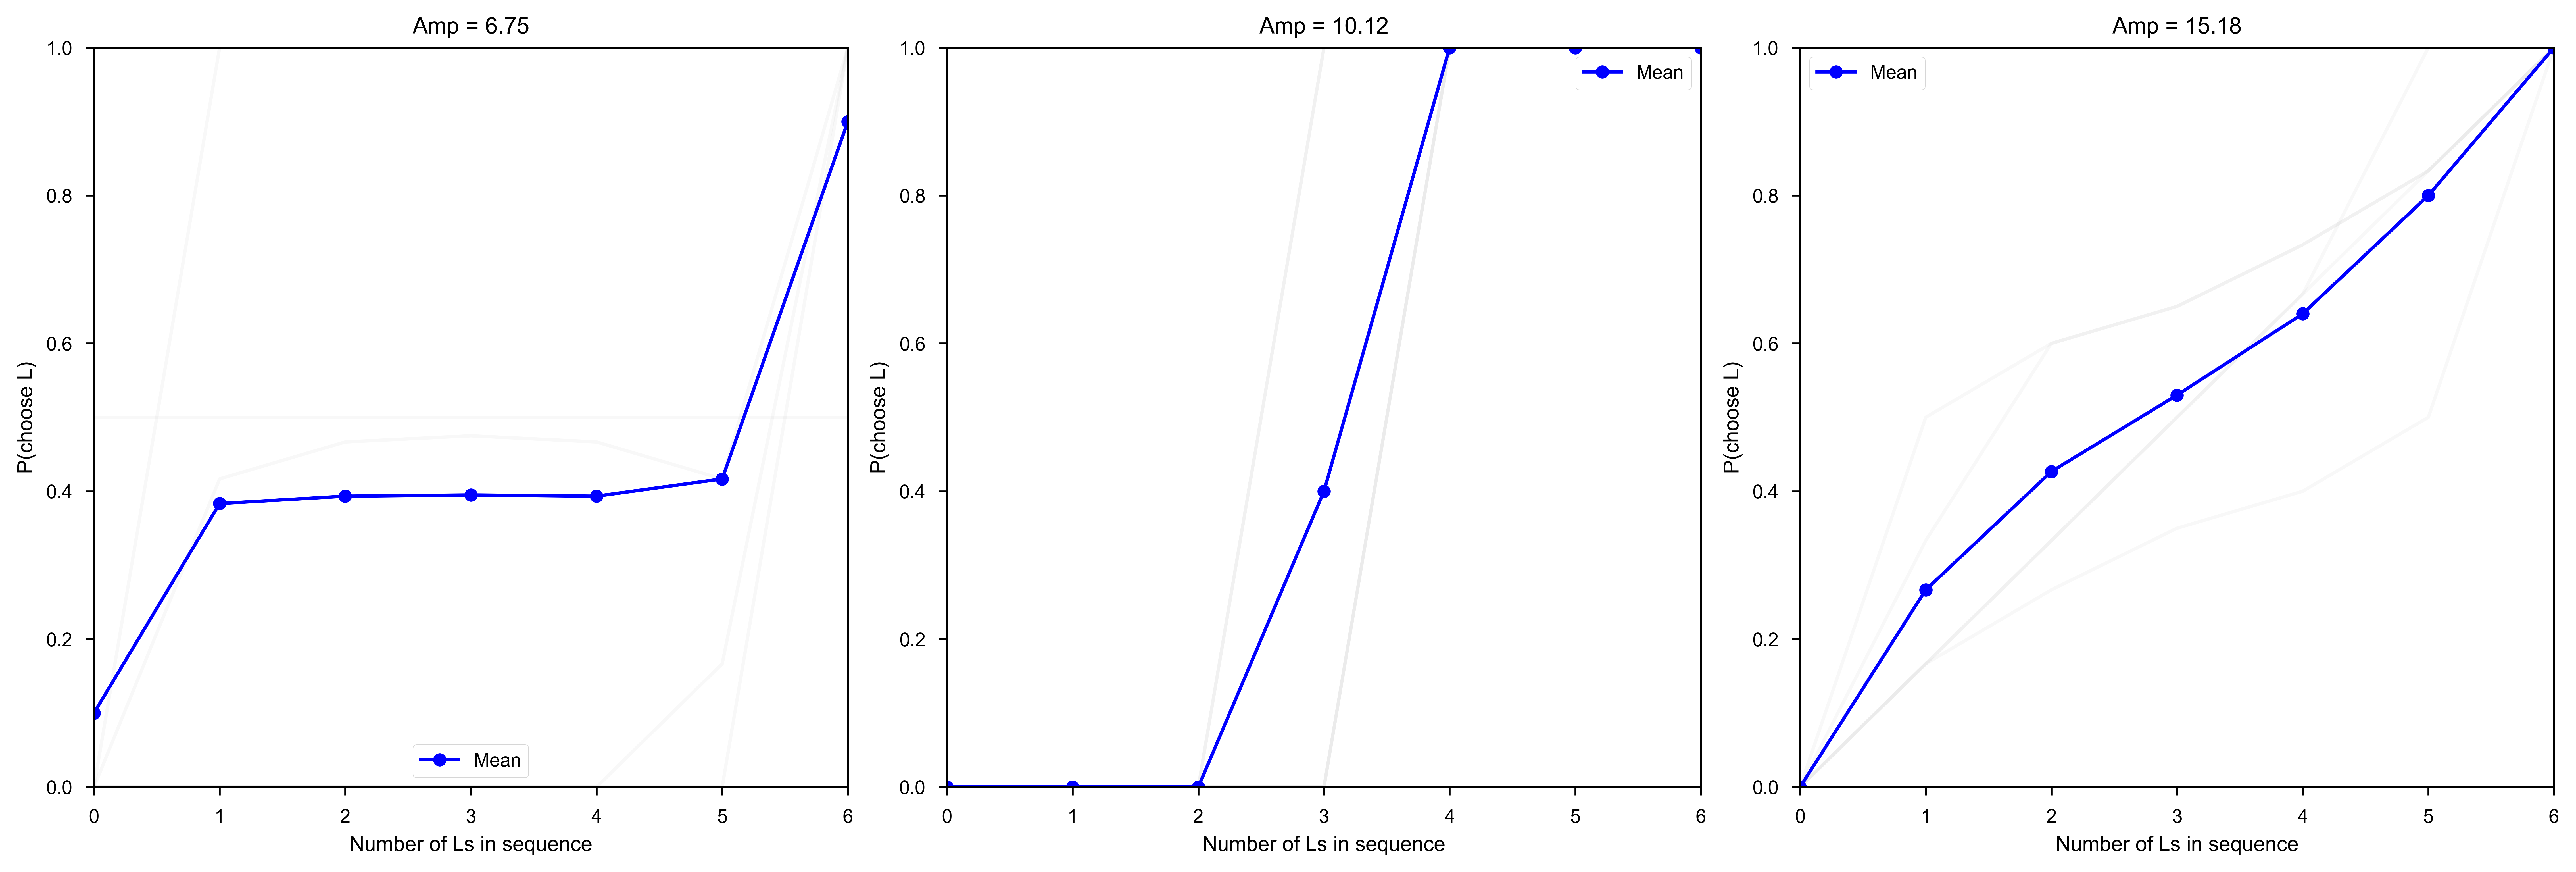

In [11]:
def plot_p_curves(curves, ax):
    ax.plot(np.arange(seq_len + 1), curves.T, color='gray', alpha=0.05)
    mean_p = np.mean(curves, axis=0)
    ax.plot(np.arange(seq_len + 1), mean_p, '-o', color='blue', label='Mean')
    ax.legend()
    ax.set_xlabel('Number of Ls in sequence')
    ax.set_ylabel('P(choose L)')
    
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')
for i, amp in enumerate(amps):
    plot_p_curves(p_curves[i], axs[i])
    axs[i].set_title(f'Amp = {amp:.2f}')
    axs[i].set_ylim(0, 1)
    axs[i].set_xlim(0, seq_len)

In [12]:
df_decisions = pd.DataFrame({i: decision_dicts[i] for i in range(len(decision_dicts))})

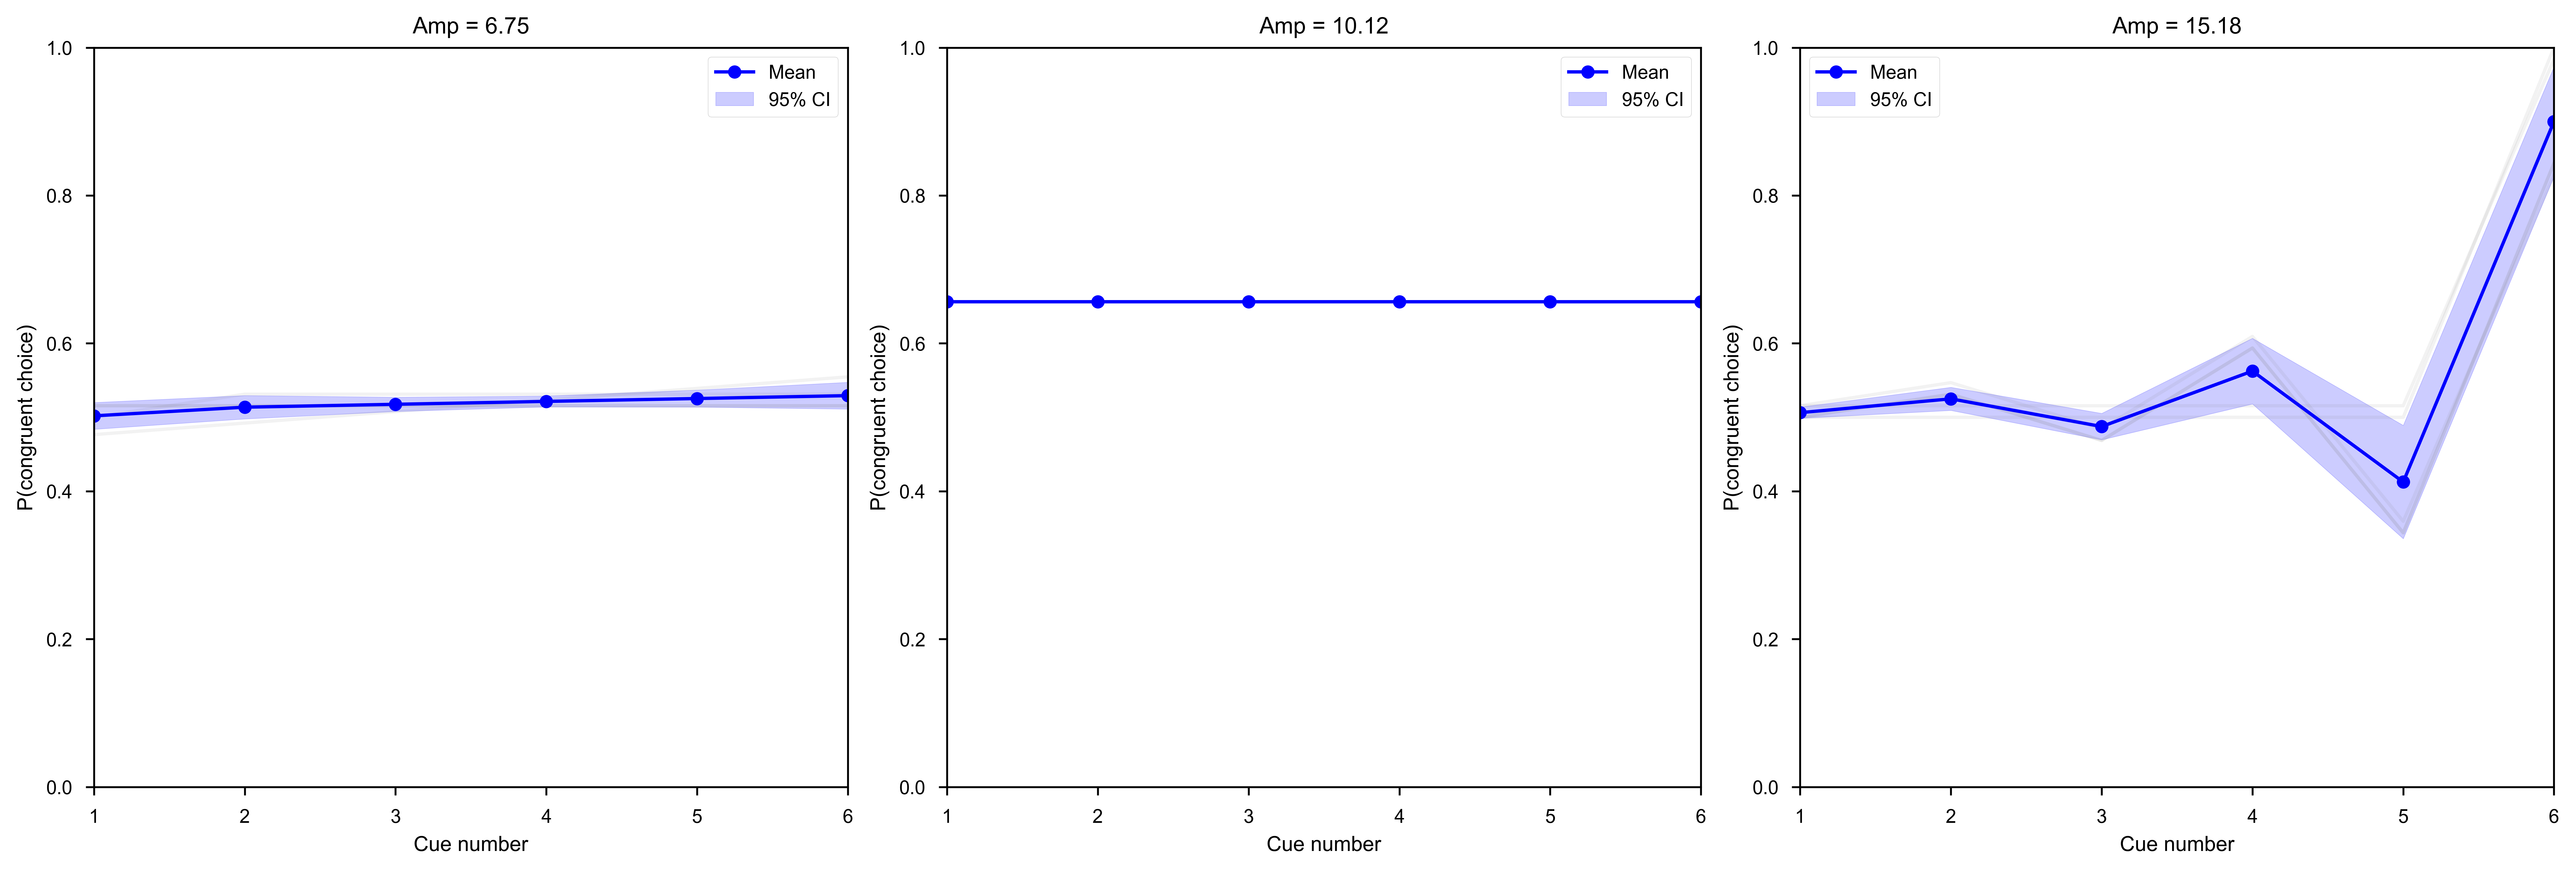

In [13]:
def p_congruent(ax, columns, reliabilities, threshold=0.5):
    # columns is a subset of a DataFrame with decisions
    prob_congruent = np.zeros((seq_len, len(columns.columns))) # rows: position in sequence, cols: different networks
    for i in range(seq_len):
        cue = [s[i] for s in columns.index]
        for j, col in enumerate(columns.columns):
            decisions = columns[col].values
            congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
            prob_congruent[i, j] = np.mean(congruent)

    prob_congruent = prob_congruent[:, reliabilities > threshold]
    ax.plot(np.arange(seq_len) + 1, prob_congruent, color='gray', alpha=0.1)
    ax.plot(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1), '-o', color='blue', label='Mean')
    sem_pc = scipy.stats.sem(prob_congruent, axis=1)
    ax.fill_between(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1) - 1.96 * sem_pc, np.mean(prob_congruent, axis=1) + 1.96 * sem_pc, color='blue', alpha=0.2, label='95% CI')
    ax.set_xlabel('Cue number')
    ax.set_ylabel('P(congruent choice)')
    ax.legend()
    
fig, ax = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')
for i, amp in enumerate(amps):
    p_congruent(ax[i], df_decisions[df_decisions.columns[i*n_kernels:(i+1)*n_kernels]], new_reliabilities[i], threshold=0.5)
    ax[i].set_title(f'Amp = {amp:.2f}')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(1, seq_len)


In [14]:
def get_kernel(i):
    rng = np.random.default_rng(i)
    
    # make kernels -- same mean
    l_kernel = rng.lognormal(0, 1, numPairs)
    l_kernel = l_kernel / np.sum(l_kernel) * numPairs
    l_kernel = np.round(l_kernel, 5)
    r_kernel = rng.lognormal(0, 1, numPairs)
    r_kernel = r_kernel / np.sum(r_kernel) * numPairs
    r_kernel = np.round(r_kernel, 5)
    
    return l_kernel, r_kernel

# print the three kernels
for i in np.argsort(reliabilities)[-n_kernels:]:
    l_kernel, r_kernel = get_kernel(i)
    print(f"Kernel {i}:")
    print("Left kernel:", l_kernel)
    print("Right kernel:", r_kernel)
    print()

Kernel 960:
Left kernel: [0.1783  0.65339 0.14086 0.40102 3.62643]
Right kernel: [1.32267 1.04578 0.55299 0.83298 1.24556]

Kernel 288:
Left kernel: [1.21472 0.91659 0.77731 0.49401 1.59737]
Right kernel: [3.40125 0.45116 0.62546 0.36465 0.15748]

Kernel 715:
Left kernel: [0.93031 0.74882 1.3156  0.51283 1.49244]
Right kernel: [0.71141 0.57066 0.19235 0.489   3.03657]

Kernel 157:
Left kernel: [0.64237 0.18941 0.40902 3.46344 0.29576]
Right kernel: [0.42449 0.66482 0.86814 1.78866 1.25389]

Kernel 202:
Left kernel: [3.86138 0.3043  0.21303 0.42206 0.19923]
Right kernel: [1.67796 0.89517 0.70257 1.52078 0.20352]

